# Описание проекта

Магазин по продаже автомобилей с пробегом разрабатывает приложение, в котором можно быстро узнать рыночную стоимость своего автомобиля. Необходимо построить модель для определения стоимости. 

Заказчику важны:
* качество предсказания;
* скорость предсказания;
* время обучения.

# 1. Подготовка данных

## Предобработка данных

### Вводная часть

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import display as d
import warnings

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, r2_score, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

Настроим среду.

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
sns.set()
warnings.filterwarnings("ignore")
r_state = 123

### Открытие файла с данными и первичный просмотр

Загрузим файл с данными и откроем его.

In [3]:
try:
    autos = pd.read_csv('/datasets/autos.csv')
except:
    autos = pd.read_csv('autos.csv')

autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Просмотрим информацию о данных.

In [4]:
autos_original_amount = autos.shape[0]
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Файл открылся корректно. Данные распознались корректно.

В некоторых столбцах имеются пропуски, попробуем их заполнить. В ряде случаев необходимо изменить тип данных, учитывая некоторые особенности, связанные с последующим применением этих данных в моделях машинного обучения.

Также необходимо выполнить очистку данных от выбросов, аномалий, дубликатов и т.п.

Выполним замену имён столбцов.

In [5]:
try:
    autos = autos.rename(columns={
        'DateCrawled': 'crawled',
        'Price': 'price',
        'VehicleType': 'vehicle_type',
        'RegistrationYear': 'reg_year',
        'Gearbox': 'gearbox',
        'Power': 'power',
        'Model': 'model',
        'Kilometer': 'mileage',
        'RegistrationMonth': 'reg_month',
        'FuelType': 'fuel',
        'Brand': 'brand',
        'NotRepaired': 'not_repaired',
        'DateCreated': 'created',
        'NumberOfPictures': 'pics',
        'PostalCode': 'postal_code',
        'LastSeen': 'last_seen'
    })
except:
    print('The columns have already been renamed.')

autos.head(1)

,crawled,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired,created,pics,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57


### Удаление ненужных столбцов

Некоторые из представленных столбцов не несут в себе информацию, которая может каким-либо образом помочь в оценке стоимости автомобиля, и их нужно удалить.

#### Функции

In [6]:
# The function counts unique values of year-month combinations and displays the sorted list of the ones
# Also, it displays the freshest date the table contained

def date_unique_months(s):
    print(f'"{s.name}"')
    s_dt = pd.to_datetime(s, format='%Y-%m-%d %H:%M:%S')
    s_dt = s_dt.apply(lambda x: x.strftime('%Y-%m'))
    print(f'the freshest date: {s_dt.max()}')
    d(s_dt.value_counts())

#### Данные о самой анкете (даты): *crawled*, *created*, *last_seen*

Дата скачивания анкеты из базы (*crawled*), дата создания анкеты (*created*) и дата последней активности пользователя (*last_seen*) не могут влиять на цену. Единственная ситуация, когда стоит задуматься, - слишком давние даты: можно предположить, что цена сильно завышена, анкета висит давно, и автомобилем никто не интересуется.

Посмотрим, как с этим обстоят дела в наших данных.

In [7]:
date_unique_months(autos.crawled)
date_unique_months(autos.created)
date_unique_months(autos.last_seen)

"crawled"
the freshest date: 2016-04


2016-03    296824
2016-04     57545
Name: crawled, dtype: int64

"created"
the freshest date: 2016-04


2016-03    296757
2016-04     57119
2016-02       397
2016-01        70
2015-12         9
2015-11         9
2015-09         3
2015-08         2
2015-06         1
2014-03         1
2015-03         1
Name: created, dtype: int64

"last_seen"
the freshest date: 2016-04


2016-04    200214
2016-03    154155
Name: last_seen, dtype: int64

Давних дат почти нет, вся активность - свежая. Следовательно, никаких выводов о цене - ни прямых, ни косвенных - мы сделать по этим столбцам не сможем. Их можно удалить.

Отметим лишь, что данные были собраны в апреле 2016 года (самые свежие даты - за этот месяц). Примем, что исследование проводится примерно в это же время - в апреле 2016 года.

#### Данные о владельце: *postal_code*

На цену автомобиля в некоторых случаях может влиять регион, в котором этот автомобиль эксплуатировался.

В данных же указан не регион, а лишь почтовый индекс. Посмотрим, сколько в *postal_code* имеется уникальных значений. Если немного, то этот столбец можно рассмотреть как категориальный признак. Если много, то его лучше удалить, так как пользы от него фундаментально не будет, а практически он может внести в обучение лишь ненужный сумбур.

Рассмотрим значения столбца *postal_code*.

In [8]:
postal = autos.postal_code.value_counts()
postal.head()

10115    819
65428    613
66333    343
44145    317
32257    317
Name: postal_code, dtype: int64

In [9]:
postal.describe()

count    8143.000000
mean       43.518237
std        47.438708
min         1.000000
25%        11.000000
50%        26.000000
75%        61.000000
max       819.000000
Name: postal_code, dtype: float64

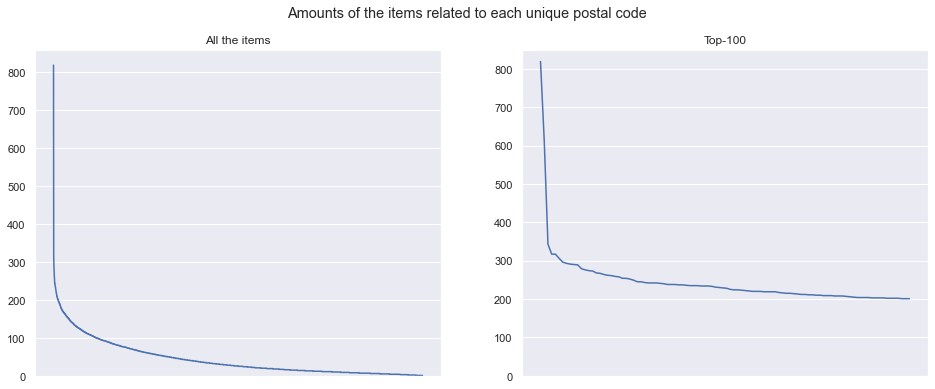

In [10]:
plt.figure(figsize=(16,6))
plt.suptitle('Amounts of the items related to each unique postal code')

plt.subplot(121)
plt.title('All the items')
plt.plot(postal.index.astype('str'), postal.values)
plt.ylim(bottom=0)
plt.xticks([])

plt.subplot(122)
plt.title('Top-100')
plt.plot(postal.head(100).index.astype('str'), postal.head(100).values)
plt.ylim(bottom=0)
plt.xticks([])

plt.show()

Более 8000 категорий, к каждой из которых в большинстве случаев относится менее 100 позиций из 354k (менее 0.03%).

Такое дробление на категории совершенно не нужно, и этот столбец следует удалить.

#### Месяц регистрации автомобиля *reg_month*

На цену автомобиля большое влияние оказывает её возраст, о котором нам говорит год выпуска *reg_year*.

Месяц в контексте возраста автомобиля обычно не упоминают. Тем не менее, на цену подержанного автомобиля (особенно свежего) месяц всё-таки может влиять: к примеру, январь 2018 года и декабрь 2018 года - это разный "2018 год".

Поэтому столбец *reg_month* мы удалять не будем.

#### Удаление столбцов

Удалим ненужные столбцы, за исключением *created*: он понадобится для анализа столбцов *reg_year* и *reg_month* и будет удалён позднее.

In [11]:
autos.drop(columns=['crawled', 'last_seen', 'postal_code'], inplace=True)
autos.head(1)

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired,created,pics
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0


Столбец *created* пока приведём к типу datetime.

In [12]:
autos.created = pd.to_datetime(autos.created, format='%Y-%m-%d %H:%M:%S')
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   price         354369 non-null  int64         
 1   vehicle_type  316879 non-null  object        
 2   reg_year      354369 non-null  int64         
 3   gearbox       334536 non-null  object        
 4   power         354369 non-null  int64         
 5   model         334664 non-null  object        
 6   mileage       354369 non-null  int64         
 7   reg_month     354369 non-null  int64         
 8   fuel          321474 non-null  object        
 9   brand         354369 non-null  object        
 10  not_repaired  283215 non-null  object        
 11  created       354369 non-null  datetime64[ns]
 12  pics          354369 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 35.1+ MB


### Удаление неинформативных строк

В датасете есть строки, в которых почти все значения пропущены. Такие строки не несут в себе никакой полезной информации, и заполнять их синтетическими данными нет никакого смысла - целесообразнее их удалить.

In [13]:
autos.head(1)

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired,created,pics
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0


Сформируем условие и посмотрим, сколько объектов под него подпадает.

In [14]:
autos_nan_index = autos[
    pd.isna(autos.vehicle_type)
    & pd.isna(autos.gearbox)
    & pd.isna(autos.model)
    & pd.isna(autos.fuel)
    & pd.isna(autos.not_repaired)
    & (autos.power == 0)
].index

autos.loc[autos_nan_index].count().max()

2021

Таких объектов - не много. Удалим их.

In [15]:
autos.drop(index=autos_nan_index, inplace=True)
autos.reset_index(drop=True, inplace=True)

### Дубликаты, пропуски, выбросы, аномалии

#### Функции

In [16]:
# The function fills NaN-cells with KNeighborsClassifier algorithm

def knn_fillna(df, feat_name_list, target_name, classifier=True):
    condition = True
    for feat in feat_name_list:
        condition = condition & (pd.isna(df[feat]) == False)

    sample = df[condition].copy()
    
    condition = condition & (pd.isna(df[target_name]) == True)
    
    nan_filled = df[condition].count().max()
    nan_total = df[pd.isna(df[target_name]) == True].count().max()
    
    encoder = OrdinalEncoder()

    x = encoder.fit_transform(sample[pd.isna(sample[target_name]) == False][feat_name_list])
    y = sample[pd.isna(sample[target_name]) == False][target_name]

    x_test = encoder.fit_transform(sample[pd.isna(sample[target_name]) == True][feat_name_list])
    y_test = sample[pd.isna(sample[target_name]) == True][target_name]

    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=r_state)

    if classifier == True:
        knn = KNeighborsClassifier(n_jobs=-1)
    else:
        knn = KNeighborsRegressor(n_jobs=-1)
    
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_valid)
    y_test = knn.predict(x_test)
    
    y_pred_const = None
    metric_name = ''
    metric_pred = 0
    metric_const = 0
    
    if classifier == True:
        y_pred_const = np.tile(sample[target_name].value_counts().index[0], len(y_pred))
        metric_name = 'F1-score'
        metric_pred = f1_score(y_valid, y_pred, average='micro')
        metric_const = f1_score(y_valid, y_pred_const, average='micro')
    else:
        y_pred_const = np.tile(sample[target_name].median(), len(y_pred))
        metric_name = 'R2-score'
        metric_pred = r2_score(y_valid, y_pred)
        metric_const = r2_score(y_valid, y_pred_const)

    print('column "{}"\n\nNaN:\nfilled:   {} ({:.1%})\nunfilled: {} ({:.1%})\n\n{}:\nvalid sample: {:.3f}\nconstant:     {:.3f}\n'
          .format(target_name,
                  nan_filled,
                  nan_filled/nan_total,
                  nan_total-nan_filled,
                  (nan_total-nan_filled)/nan_total,
                  metric_name,
                  metric_pred,
                  metric_const
                 )
         )
    
    #!!! align to: index, condition, autos[target_name][condition]
    return sample[condition].index, condition, pd.Series(data=y_test, index=sample[condition].index) 

#### Проверка на наличие дубликатов

Проверим датасет на наличие дубликатов.

In [17]:
autos.duplicated().sum()

11739

Дубликаты могут отрицательно повлиять на обучение модели: повторяющиеся данные имеют при обучении больший вес, а у нас по смыслу задачи веса объектов - равные. Количество дубликатов - небольшое, и их вполне можно удалить.

Удалим дубликаты.

In [18]:
autos.drop_duplicates(inplace=True)
autos.reset_index(drop=True, inplace=True)
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340609 entries, 0 to 340608
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   price         340609 non-null  int64         
 1   vehicle_type  305693 non-null  object        
 2   reg_year      340609 non-null  int64         
 3   gearbox       323526 non-null  object        
 4   power         340609 non-null  int64         
 5   model         323191 non-null  object        
 6   mileage       340609 non-null  int64         
 7   reg_month     340609 non-null  int64         
 8   fuel          310182 non-null  object        
 9   brand         340609 non-null  object        
 10  not_repaired  272904 non-null  object        
 11  created       340609 non-null  datetime64[ns]
 12  pics          340609 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 33.8+ MB


#### Пропуски, выбросы, аномалии, типы данных

В данном подразделе мы будем выполнять предобработку данных в разрезе столбцов. Будем рассматривать каждый столбец в отдельности: заполнять в нём пропуски, проверять его на наличие выбросов и аномалий, корректировать тип данных. Столбцы находятся в слишком "разношерстном" состоянии, и комплексная их обработка представляется в данном случае эффективнее, нежели прогонять сразу все столбцы по каждому этапу в отдельности.

##### price

Рассмотрим статистики и частотное распределение.

In [19]:
autos.price.describe()

count    340609.000000
mean       4416.713707
std        4513.730663
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

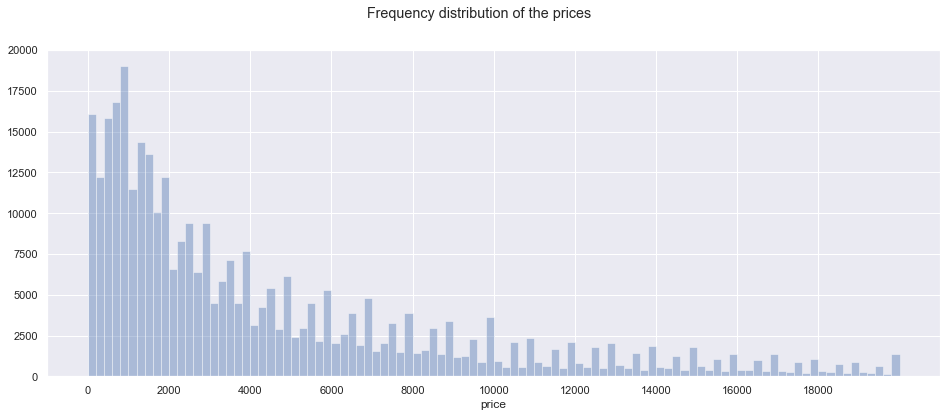

In [20]:
plt.figure(figsize=(16,6))
plt.suptitle('Frequency distribution of the prices')
sns.distplot(autos.price, bins=100, kde=False)
plt.xticks(range(0, int(autos.price.describe()['max']), int(autos.price.describe()['max'] / 10)))
plt.show()

Цена распределена по распределению Пуассона, что ожидаемо. Вместе с тем, видно большое количество околонулевых значений. Рассмотрим их детальнее.

In [21]:
autos.price.value_counts().sort_index().head()

0    9826
1    1059
2      11
3       5
5      24
Name: price, dtype: int64

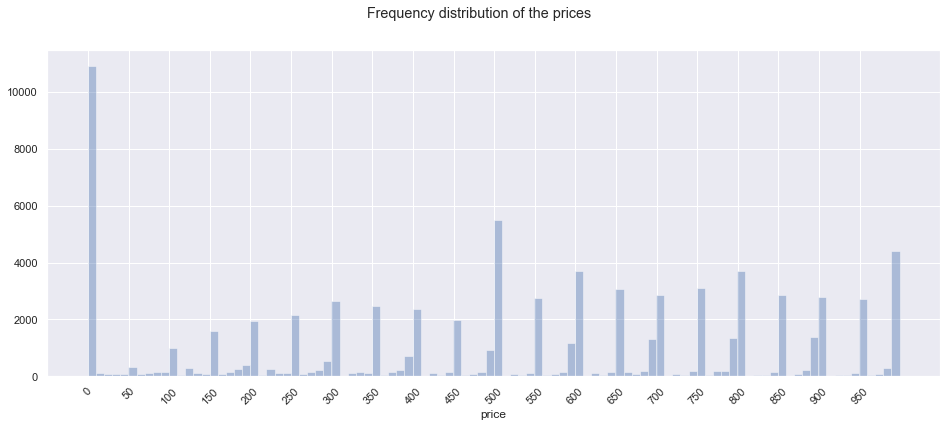

In [22]:
plt.figure(figsize=(16,6))
plt.suptitle('Frequency distribution of the prices')
sns.distplot(autos.price[autos.price < 1000], bins=100, kde=False)
plt.xticks(range(0, 1000, 50), rotation=45)
plt.show()

Цену в большинстве случаев округляют до 50. До 500 и до 1000 - ещё больше случаев.

Имеется также много случаев, когда цена равна 0 или 1 евро. Посмотрим, что это за автомобили. Поскольку год выпуска автомобиля мы ещё не предобрабатывали, просто исключим из выборки заведомо некорректные значения: оставшихся для оценки будет достаточно.

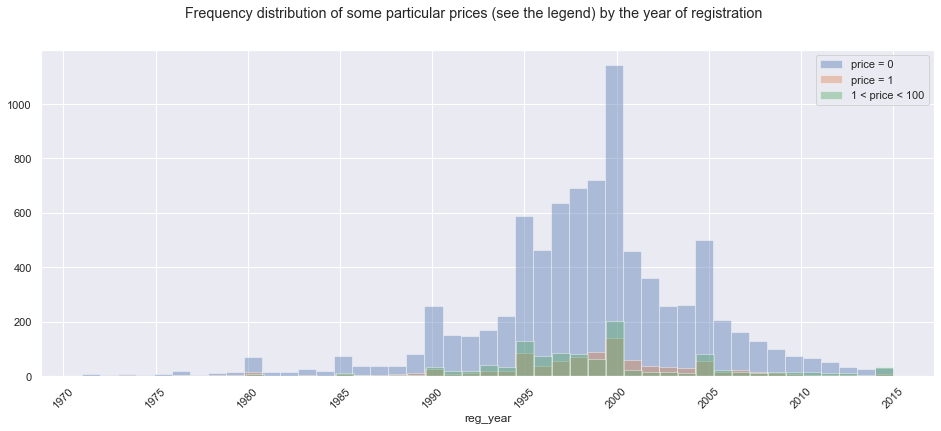

In [23]:
plt.figure(figsize=(16,6))
plt.suptitle('Frequency distribution of some particular prices (see the legend) by the year of registration')
legend = []
bounds_price = [0, 1, 100]
bounds_reg_year = [1970, 2016]

sns.distplot(autos[(autos.price == bounds_price[0])
                   & (autos.reg_year > bounds_reg_year[0])
                   & (autos.reg_year < bounds_reg_year[1])].reg_year,
             bins=45, kde=False)
legend.append(f'price = {bounds_price[0]}')

sns.distplot(autos[(autos.price == bounds_price[1])
                   & (autos.reg_year > bounds_reg_year[0])
                   & (autos.reg_year < bounds_reg_year[1])].reg_year,
             bins=44, kde=False)
legend.append(f'price = {bounds_price[1]}')

sns.distplot(autos[(autos.price > bounds_price[1])
                   & (autos.price < bounds_price[2])
                   & (autos.reg_year > bounds_reg_year[0])
                   & (autos.reg_year < bounds_reg_year[1])].reg_year,
             bins=40, kde=False)
legend.append(f'{bounds_price[1]} < price < {bounds_price[2]}')

plt.xticks(range(1970, 2020, 5), rotation=45)
plt.legend(legend)
plt.show()

В основном, за бесценок хотят избавиться от старых автомобилей возрастом 15-25 лет. Цену, близкую к нулю, не стоит считать ошибкой: по тем или иным причинам люди иногда хотят быстро избавиться от ненужных старых вещей. Тем более, в Европе: услуги по утилизации - платные, а просто куда-то выбросить или где-то оставить - запрещено. Поэтому отдать бесплатно может оказаться даже дешевле.

Однако, на гистограмме можно заметить следующую особенность: количество предложений с низкой ценой значительно больше среди автомобилей "круглых" годов выпуска, кратных 5. Глубоко копать в этом направлении в контексте поставленной задачи смысла нет: просто отметим это как аномалию, причины которой - нерыночные.

Несмотря на то, что околонулевые цены, вероятно, всё же являются реальными, влияющие на цену **факторы**, которыми руководствовались владельцы этих автомобилей, - **не такие**, как в "обычных" случаях. Выставляя автомобиль за нормальную рыночную цену, владелец стремится продать автомобиль максимально выгодно, соотнося возможную выручку и разумные сроки продажи. А в случае предложения отдать автомобиль даром владельца не интересует выручка от продажи. Его интересует только максимально быстрый и, желательно, наименее затратный путь отчуждения имущества. **Рыночная** цена в этом случае для владельца **не важна**.

Поскольку, согласно ТЗ, нам необходимо прогнозировать рыночную стоимость автомобиля, от нерыночных объектов в датасете стоит избавится. Посмотрим, много ли таких объектов.

In [24]:
autos[autos.price < 100].count().max()

12091

Объектов с нерыночной ценой - не много, и их можно удалить. Удалим их.

In [25]:
autos.drop(index=autos[autos.price < 100].index, inplace=True)
autos.reset_index(drop=True, inplace=True)

In [26]:
d(autos.price.describe())
autos.info()

count    328518.000000
mean       4579.069500
std        4514.537164
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328518 entries, 0 to 328517
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   price         328518 non-null  int64         
 1   vehicle_type  297484 non-null  object        
 2   reg_year      328518 non-null  int64         
 3   gearbox       313979 non-null  object        
 4   power         328518 non-null  int64         
 5   model         312812 non-null  object        
 6   mileage       328518 non-null  int64         
 7   reg_month     328518 non-null  int64         
 8   fuel          301635 non-null  object        
 9   brand         328518 non-null  object        
 10  not_repaired  266567 non-null  object        
 11  created       328518 non-null  datetime64[ns]
 12  pics          328518 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 32.6+ MB


##### reg_year

Рассмотрим значения столбца.

In [27]:
reg_year_unique = autos.reg_year.unique()
reg_year_unique.sort()
reg_year_unique

array([1000, 1001, 1039, 1234, 1300, 1400, 1500, 1600, 1602, 1800, 1910,
       1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2290, 2500, 2800,
       2900, 3000, 3700, 4000, 4500, 4800, 5000, 5555, 5900, 5911, 6000,
       7000, 7100, 7800, 8200, 8500, 9000, 9450, 9999], dtype=int64)

Имеются как явно бессмысленные значения, так и некоторые аномалии: представлена первая половина ХХ века и автомобили из будущего (2017, 2018, 2019 годы, а также другие, по которым анкеты размещены раньше, чем автомобили были выпущены).

Для начала удалим ошибочные значения, а затем рассмотрим аномалии.

In [28]:
autos[(autos.reg_year < 1900) | (autos.reg_year > 2020)].count().max()

87

In [29]:
autos.drop(index=autos[(autos.reg_year < 1900) | (autos.reg_year > 2020)].index, inplace=True)

In [30]:
autos.reg_year.value_counts().sort_index()

1910       23
1923        2
1925        1
1927        1
1928        2
1929        6
1930        2
1931        1
1932        3
1933        2
1934        2
1935        3
1936        3
1937       10
1938        8
1940        2
1941        2
1942        2
1943        4
1944        2
1945        4
1946        1
1947        2
1948        2
1949        1
1950       14
1951       10
1952        8
1953       14
1954        9
1955       13
1956       24
1957       13
1958       19
1959       29
1960      102
1961       36
1962       39
1963       55
1964       58
1965       79
1966      106
1967       94
1968       98
1969      113
1970      230
1971      159
1972      206
1973      159
1974      160
1975      133
1976      151
1977      162
1978      262
1979      257
1980      428
1981      239
1982      294
1983      390
1984      372
1985      605
1986      484
1987      616
1988      871
1989     1200
1990     2247
1991     2523
1992     2751
1993     3131
1994     4446
1995     8387
1996  

Количество ретро-автомобилей (до 1960 года) в выборке достаточно мало, и их можно безболезненно удалить. А удалить такие объекты стоит потому, что ценообразование на них весьма **отличается** от такового для современных авто: они рассматриваются скорее как предметы коллекционирования, чем как транспортные средства в обычном понимании. При их покупке влияние оказывают совершенно **иные** факторы, нежели в обычном случае.

В выборке имеются и автомобили с более поздней датой выпуска, чем дата выгрузки базы, дата создания анкеты или, например, дата последней активности пользователя. Эти строки следует удалить, так как данные в них - ошибочные, и им доверять нельзя.

Удалим из выборки автомобили до 1960 года выпуска, а также те, у которых дата выпуска некорректна - более поздняя, чем дата создания анкеты.

In [31]:
autos[autos.reg_year < 1960].count().max()

244

In [32]:
autos[(autos.reg_year > autos.created.dt.year) 
      | ((autos.reg_year == autos.created.dt.year) & (autos.reg_month > autos.created.dt.month))
     ].count().max()

18136

In [33]:
autos.drop(index=autos[(autos.reg_year < 1960) 
                       | (autos.reg_year > autos.created.dt.year) 
                       | ((autos.reg_year == autos.created.dt.year) & (autos.reg_month >= autos.created.dt.month))
                      ].index,
           inplace=True)

autos.reset_index(drop=True, inplace=True)

In [34]:
autos.reg_year.value_counts().sort_index()

1960      102
1961       36
1962       39
1963       55
1964       58
1965       79
1966      106
1967       94
1968       98
1969      113
1970      230
1971      159
1972      206
1973      159
1974      160
1975      133
1976      151
1977      162
1978      262
1979      257
1980      428
1981      239
1982      294
1983      390
1984      372
1985      605
1986      484
1987      616
1988      871
1989     1200
1990     2247
1991     2523
1992     2751
1993     3131
1994     4446
1995     8387
1996     9954
1997    13447
1998    16552
1999    21199
2000    21580
2001    18941
2002    18028
2003    18721
2004    18541
2005    20397
2006    18790
2007    16263
2008    14575
2009    13796
2010    10211
2011     9366
2012     6848
2013     3880
2014     2390
2015     1076
2016     3215
Name: reg_year, dtype: int64

Удалим столбец *created*.

In [35]:
autos.drop(columns='created', inplace=True)
autos.columns

Index(['price', 'vehicle_type', 'reg_year', 'gearbox', 'power', 'model',
       'mileage', 'reg_month', 'fuel', 'brand', 'not_repaired', 'pics'],
      dtype='object')

##### vehicle_type

Посмотрим, какие значения есть в этом столбце.

In [36]:
autos.vehicle_type.value_counts(dropna=False)

sedan          85562
small          74794
wagon          61019
bus            27376
convertible    19118
coupe          15052
NaN            12255
suv            11269
other           2968
Name: vehicle_type, dtype: int64

Заполним пропуски по столбцам *brand* и *model*. Несмотря на то, что зачастую одна и та же модель выпускается в разных кузовах, на основе тех данных, которыми мы сейчас располагаем, такое сопоставление даст наиболее точный результат.

Поиск подходящих значений выполним автоматизированно при помощи модели машинного обучения. Алгоритм - Метод Ближайших Соседей (*KNeighborsClassifier* из библиотеки *scilit-learn*).

Алгоритм реализован в функции *knn_fillna*.

Описание работы функции ***knn_fillna***:
* Из датасета выделяется выборка для конкретной задачи. Необходимое условие - в признаках нет пропусков.
* Выборка делится на обучающую, валидационную и тестовую выборки.
* Модель обучается на обучающей выборке и проверяется на валидационной (возвращает массив с предсказаниями).
* Константная модель: формируется массив, заполненный модой (классификатор) или медианой (регрессор) целевого признака (предсказания константной модели).
* Рассчитываются метрики *F1-score* (классификатор) или *R2-score* (регрессор) для модели и для константной модели.
* Рассчитываются предсказания на тестовой выборке (они же - искомые).
* Выводятся результаты расчёта и возвращается массив рассчитанных значений.

In [37]:
%%time
index_filled, condition, autos.vehicle_type[condition] = knn_fillna(autos,
                                                                    ['reg_year', 'model', 'brand'],
                                                                    'vehicle_type')

column "vehicle_type"

NaN:
filled:   10546 (86.1%)
unfilled: 1709 (13.9%)

F1-score:
valid sample: 0.665
constant:     0.287

Wall time: 7.46 s


Для задачи заполнения пропусков качество модели получилось вполне приемлемым. Модель адекватна: метрика *F1-score* на тестовых данных существенно выше, чем у константной модели.

Часть объектов осталась незаполненной (имелись пропуски в признаках), - с ними разберёмся позже.

Посмотрим на первые строки датасета из тех, в которых заполнялись пропуски.

In [38]:
autos.loc[index_filled].head(10)

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired,pics
0,480,small,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0
14,300,sedan,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,0
31,1500,small,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,0
43,1400,sedan,2016,manual,55,other,5000,1,NaN,hyundai,NaN,0
59,2300,sedan,1997,manual,150,5er,150000,3,NaN,bmw,no,0
65,800,convertible,2000,manual,90,golf,150000,2,gasoline,volkswagen,NaN,0
78,250,suv,2000,NaN,60,ka,150000,0,NaN,ford,NaN,0
80,8390,sedan,2009,NaN,0,insignia,150000,0,NaN,opel,NaN,0
93,900,small,1995,manual,90,civic,150000,3,petrol,honda,NaN,0
110,8000,small,2009,manual,0,golf,100000,10,petrol,volkswagen,no,0


Похоже на правду. Продолжаем.

##### gearbox

Посмотрим, какие значения есть в этом столбце.

In [39]:
autos.gearbox.value_counts(dropna=False)

manual    237084
auto       59901
NaN        12428
Name: gearbox, dtype: int64

Попробуем заполнить пропуски при помощи функции *knn_fillna*, опираясь на признаки *vehicle_type*, *reg_year*, *model*, *brand*. От других признаков тип КПП вряд ли зависит, и их мы включать в модель не будем.

Заполним пропуски.

In [40]:
%%time
index_filled, condition, autos.gearbox[condition] = knn_fillna(autos,
                                                               ['vehicle_type', 'reg_year', 'model', 'brand'],
                                                               'gearbox')

column "gearbox"

NaN:
filled:   11113 (89.4%)
unfilled: 1315 (10.6%)

F1-score:
valid sample: 0.840
constant:     0.802

Wall time: 8.25 s


Модель превзошла константную по качеству предсказания, но ненамного. Столь высокое значение метрики у константной модели обусловлено дисбалансом классов. Как и в предыдущем случае, для задачи заполнения пропусков (учитывая их небольшую долю в выборке) такого качества вполне хватит.

Посмотрим на первые строки из числа заполненных.

In [41]:
autos.loc[index_filled].head(10)

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired,pics
14,300,sedan,2016,manual,60,polo,150000,0,petrol,volkswagen,NaN,0
27,245,sedan,1994,manual,0,golf,150000,2,petrol,volkswagen,no,0
31,1500,small,2016,manual,0,kangoo,150000,1,gasoline,renault,no,0
57,1200,coupe,2001,manual,0,astra,150000,0,NaN,opel,NaN,0
78,250,suv,2000,manual,60,ka,150000,0,NaN,ford,NaN,0
80,8390,sedan,2009,auto,0,insignia,150000,0,NaN,opel,NaN,0
96,350,small,1998,manual,0,corsa,150000,2,petrol,opel,NaN,0
114,3390,coupe,2000,manual,0,3er,150000,2,NaN,bmw,NaN,0
129,150,sedan,1985,manual,0,100,150000,4,petrol,audi,NaN,0
176,3200,wagon,2006,auto,0,a3,150000,11,gasoline,audi,no,0


##### power

Рассмотрим значения в столбце.

In [42]:
autos.power.describe()

count    309413.000000
mean        113.092808
std         185.877342
min           0.000000
25%          74.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Имеются аномалии: нулевые и слишком большие значения.

Удалим заведомо нереальные значения.

In [43]:
bound_unreal_power = 600
d(autos[autos.power > bound_unreal_power].count().max())
autos.drop(index=autos[autos.power > bound_unreal_power].index, inplace=True)

309

Рассмотрим околонулевые значения.

In [44]:
autos.power.value_counts().sort_index().head()

0    28332
1       21
2        8
3        8
4       30
Name: power, dtype: int64

Нулевых значений - много, и их следует рассматривать как пропуски.

Заполним пропуски при помощи функции *knn_fillna* по признакам *vehicle_type*, *reg_year*, *gearbox*, *model*, *brand*, предварительно заменив нули пропусками.

In [45]:
autos.power[autos.power == 0] = pd.Series(data=np.tile(np.nan, len(autos.power[autos.power == 0])),
                                          index=autos.power[autos.power == 0].index)
pd.isna(autos.power).sum()

28332

In [46]:
%%time
index_filled, condition, autos.power[condition] = knn_fillna(autos, 
                                                             ['vehicle_type', 'reg_year', 'gearbox', 'model', 'brand'], 
                                                             'power',
                                                             classifier=False)

column "power"

NaN:
filled:   25518 (90.1%)
unfilled: 2814 (9.9%)

R2-score:
valid sample: 0.690
constant:     -0.022

Wall time: 3.39 s


Качество заполнения пропусков - хорошее.

In [47]:
autos.power = round(autos.power)
autos.loc[index_filled].head(10)

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired,pics
0,480,small,1993,manual,75.0,golf,150000,0,petrol,volkswagen,NaN,0
27,245,sedan,1994,manual,137.0,golf,150000,2,petrol,volkswagen,no,0
31,1500,small,2016,manual,90.0,kangoo,150000,1,gasoline,renault,no,0
45,4700,wagon,2005,manual,121.0,signum,150000,0,NaN,opel,no,0
46,550,wagon,1999,manual,92.0,astra,150000,8,gasoline,opel,yes,0
57,1200,coupe,2001,manual,147.0,astra,150000,0,NaN,opel,NaN,0
58,800,small,1993,manual,90.0,polo,150000,3,petrol,volkswagen,no,0
76,2400,sedan,2003,manual,137.0,a4,150000,9,gasoline,audi,NaN,0
80,8390,sedan,2009,auto,207.0,insignia,150000,0,NaN,opel,NaN,0
84,4290,bus,2008,manual,84.0,combo,150000,2,gasoline,opel,no,0


Построим диаграмму boxplot и частотную диаграмму.

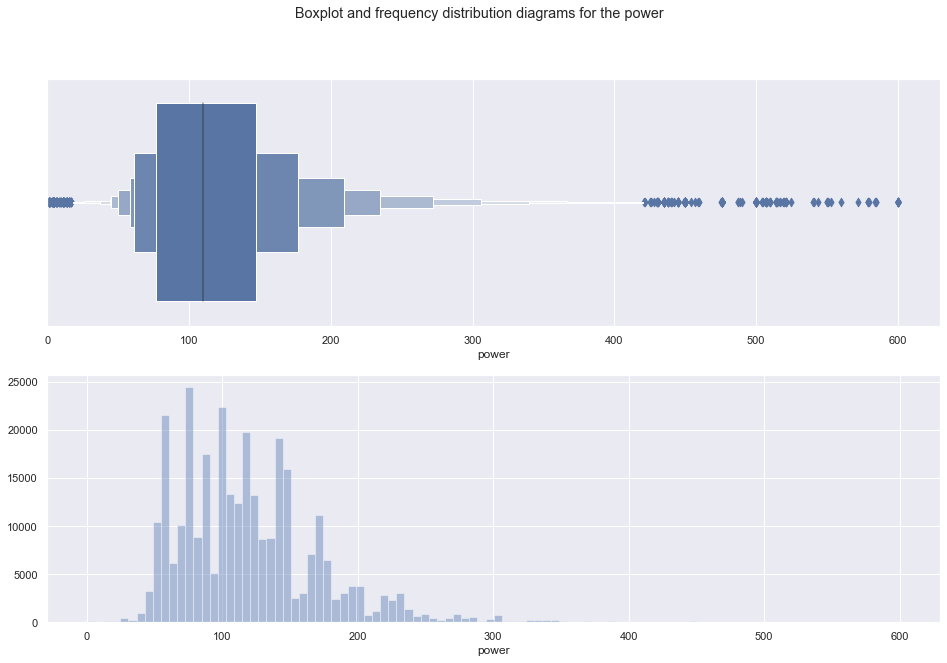

In [48]:
plt.figure(figsize=(16,10))
plt.suptitle('Boxplot and frequency distribution diagrams for the power')

plt.subplot(211)
sns.boxenplot(autos.power)
plt.xlim(left=0)

plt.subplot(212)
sns.distplot(autos.power, bins=100, kde=False)

plt.show()

Гистограмма имеет вид распределения Пуассона.

Посмотрим, чему равны квантили, отстоящие от среднего на 3&sigma;, и сколько значений лежит за этими границами.

In [49]:
three_sigma = 0.9972
bounds = [autos.power.quantile((1 - three_sigma) / 2),
          autos.power.quantile((1 + three_sigma) / 2)]

print('-3 sigma:\nbound:  {}\namount: {}\n\n3 sigma:\nbound:  {}\namount: {}'
      .format(bounds[0],
              autos[autos.power < bounds[0]].count().max(),
              bounds[1],
              autos[autos.power > bounds[1]].count().max()
             )
     )

-3 sigma:
bound:  24.0
amount: 415

3 sigma:
bound:  387.0
amount: 413


За этими границами лежат выбросы. Удалим их.

In [50]:
autos.drop(index=autos[(autos.power < bounds[0]) | (autos.power > bounds[1])].index, inplace=True)
autos.reset_index(drop=True, inplace=True)

In [51]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308276 entries, 0 to 308275
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         308276 non-null  int64  
 1   vehicle_type  306588 non-null  object 
 2   reg_year      308276 non-null  int64  
 3   gearbox       306982 non-null  object 
 4   power         305462 non-null  float64
 5   model         295326 non-null  object 
 6   mileage       308276 non-null  int64  
 7   reg_month     308276 non-null  int64  
 8   fuel          288744 non-null  object 
 9   brand         308276 non-null  object 
 10  not_repaired  254654 non-null  object 
 11  pics          308276 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 28.2+ MB


##### model

Посмотрим на значения столбца *model*.

In [52]:
autos.model.unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'kadett', 'kangoo', 'one', 'fortwo', 'clio',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'megane', 'lupo', 'r19',
       'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up',
       'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio',
       'touareg', 'l

Некорректных значений нет. 

Имеется ряд значений, включающих слово "reihe" (нем. - "серия", "поколение"). Посмотрим на них.

In [53]:
d(autos.brand[autos.model.str.contains('reihe') == True].value_counts())
autos[autos.model.str.contains('reihe') == True].head(10)

peugeot    8085
mazda      3834
bmw        2217
hyundai    1149
volvo       422
honda       312
Name: brand, dtype: int64

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired,pics
6,2200,convertible,2004,manual,109.0,2_reihe,150000,8,petrol,peugeot,no,0
9,2000,sedan,2004,manual,105.0,3_reihe,150000,12,petrol,mazda,no,0
72,8000,suv,2005,manual,185.0,xc_reihe,150000,8,gasoline,volvo,NaN,0
132,800,sedan,2004,manual,88.0,3_reihe,150000,9,petrol,peugeot,yes,0
136,9450,convertible,2004,manual,170.0,z_reihe,150000,12,petrol,bmw,no,0
201,1450,small,1999,manual,75.0,2_reihe,150000,8,petrol,peugeot,no,0
245,14900,convertible,2004,manual,170.0,z_reihe,70000,6,petrol,bmw,no,0
263,2000,sedan,2004,manual,122.0,6_reihe,5000,7,gasoline,mazda,no,0
269,6799,sedan,2008,manual,174.0,3_reihe,90000,9,petrol,peugeot,no,0
281,16500,coupe,2007,manual,265.0,z_reihe,150000,3,petrol,bmw,no,0


Хотя это и не строгие названия моделей, корректировать их (или удалять) мы не будем.

Несмотря на приставку "reihe", модель автомобиля в некоторых случаях всё равно указана точно (бренды "mazda", "peugeot" - добавляем запатентованные "06" - сошлось?). Тогда это не должно мешать прогнозированию цены. Либо информации о конкретной модели нет, но есть указание на серию моделей (бренды "bmw", "hyundai", "volvo", "honda"), что тоже поможет спрогнозировать цену достаточно точно.

Имеются и пропуски, которые необходимо заполнить. Заполнять пропуски будем аналогично заполнению в предыдущих столбцах.

In [54]:
%%time
index_filled, condition, autos.model[condition] = knn_fillna(autos, 
                                                             ['vehicle_type', 'reg_year', 'gearbox', 'power', 'brand'], 
                                                             'model')

column "model"

NaN:
filled:   8709 (67.3%)
unfilled: 4241 (32.7%)

F1-score:
valid sample: 0.773
constant:     0.083

Wall time: 7.11 s


Из-за пропусков в признаках довольно много осталось незаполненных пропусков в *model*. Оставим наиболее критичные признаки (они же - с наименьшим количеством пропусков) и попробуем заполнить ещё раз.

In [55]:
%%time
index_filled, condition, autos.model[condition] = knn_fillna(autos, 
                                                             ['vehicle_type', 'reg_year', 'brand'], 
                                                             'model')

column "model"

NaN:
filled:   2553 (60.2%)
unfilled: 1688 (39.8%)

F1-score:
valid sample: 0.584
constant:     0.084

Wall time: 7.75 s


С меньшей точностью, но всё же удалось заполнить ещё больше пропусков.

In [56]:
autos.loc[index_filled].head()

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired,pics
135,6799,small,2009,NaN,60.0,polo,20000,5,petrol,volkswagen,no,0
141,500,small,1999,manual,NaN,clio,150000,0,petrol,renault,no,0
142,1495,wagon,2001,NaN,64.0,golf,150000,9,gasoline,volkswagen,NaN,0
166,14000,sedan,2008,NaN,235.0,x_reihe,150000,0,NaN,bmw,no,0
277,1600,wagon,1999,manual,NaN,5er,150000,6,petrol,bmw,no,0


##### mileage

Рассмотрим столбец *mileage*.

In [57]:
autos.mileage.value_counts(dropna=False).sort_index()

5000        3869
10000        948
20000       3381
30000       3938
40000       4479
50000       5659
60000       6770
70000       7854
80000       9080
90000      10427
100000     13054
125000     32471
150000    206346
Name: mileage, dtype: int64

Проблем в этом столбце нет. Видно, что пробег принимает лишь определённые значения (точнее, имеет место определённый шаг между соседними значениями). Это вполне может и не являться ошибкой (причины округления могут быть самыми разными), а в контексте данного исследования такое округление ни на что не повлияет.

##### reg_month

In [58]:
autos.reg_month.value_counts(dropna=False).sort_index()

0     26729
1     20886
2     19271
3     30846
4     25931
5     25673
6     27781
7     24114
8     19899
9     21155
10    23108
11    21417
12    21466
Name: reg_month, dtype: int64

Месяцев в году всего двенадцать, а в столбце *reg_month* имеются значения от 0 до 12 включительно, т.е. тринадцать различных значений. При этом частоты у них близки между собой: нельзя сказать, что, например, "0" и "1" - это одна и та же категория (по причине путаницы в индексации месяцев: "0...11" или "1...12"). Поскольку в столбце нет пропусков, можно предположить, что нули - эти и есть пропуски.

Предсказать месяц регистрации автомобиля по его техническим данным невозможно. Но, поскольку этот столбец не важен для оценки автомобиля (в случае свежего автомобиля влияние всё же возможно, но весьма слабое), пропуски достаточно заполнить случайными значениями.

Один из способов - использование функции *knn_fillna*. Алгоритм уже разработан и вполне подходит. Точность в данном случае совершенно не важна, поэтому достаточно будет указать один признак.

Ещё один важный момент состоит в том, что месяц - это категориальный признак. Поэтому тип данных столбца *reg_month* необходимо преобразовать в строковый.

Преобразуем тип данных в строковый.

In [59]:
autos.reg_month = autos.reg_month.astype('str')

Удалим значения из нулевых ячеек.

In [60]:
autos.reg_month[autos.reg_month == '0'] = pd.Series(data=np.tile(np.nan, len(autos.reg_month[autos.reg_month == '0'])),
                                                  index=autos.reg_month[autos.reg_month == '0'].index)
pd.isna(autos.reg_month).sum()

26729

Заполним пропуски.

In [61]:
%%time
index_filled, condition, autos.reg_month[condition] = knn_fillna(autos,
                                                                 ['reg_year'], 
                                                                 'reg_month')

column "reg_month"

NaN:
filled:   26729 (100.0%)
unfilled: 0 (0.0%)

F1-score:
valid sample: 0.091
constant:     0.110

Wall time: 19.4 s


Никакой взаимосвязи - чистый рандом. Что и требовалось.

##### fuel

Посмотрим на значения этого столбца.

In [62]:
autos.fuel.value_counts(dropna=False)

petrol      193601
gasoline     89495
NaN          19532
lpg           4751
cng            509
hybrid         209
other          132
electric        47
Name: fuel, dtype: int64

Всё адекватно, но имеются пропуски. Заполним их при помощи функции *knn_fillna*.

In [63]:
%%time
index_filled, condition, autos.fuel[condition] = knn_fillna(autos, 
                                                             ['vehicle_type', 'reg_year', 'gearbox', 'power', 'brand'], 
                                                             'fuel')

column "fuel"

NaN:
filled:   17929 (91.8%)
unfilled: 1603 (8.2%)

F1-score:
valid sample: 0.904
constant:     0.670

Wall time: 7.32 s


Большая часть пропусков заполнена.

In [64]:
autos.loc[index_filled].head()

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired,pics
8,999,small,1998,manual,101.0,golf,150000,12,petrol,volkswagen,NaN,0
12,2500,wagon,2004,manual,131.0,passat,150000,2,gasoline,volkswagen,no,0
30,1600,other,1991,manual,75.0,kadett,70000,10,petrol,opel,NaN,0
34,7500,sedan,2002,auto,306.0,e_klasse,150000,4,petrol,mercedes_benz,NaN,0
43,1400,sedan,2016,manual,55.0,other,5000,1,petrol,hyundai,NaN,0


##### brand

Рассмотрим столбец *brand*.

In [65]:
autos.brand.value_counts(dropna=False)

volkswagen        66010
opel              34154
bmw               32629
mercedes_benz     28637
audi              25798
ford              22011
renault           15399
peugeot            9782
fiat               8229
seat               5942
skoda              5024
mazda              4952
smart              4715
citroen            4513
nissan             4378
toyota             4212
hyundai            3213
mini               2919
volvo              2879
mitsubishi         2667
honda              2452
kia                2179
suzuki             2061
alfa_romeo         2019
sonstige_autos     1987
chevrolet          1552
chrysler           1250
dacia               825
daihatsu            697
subaru              675
porsche             619
jeep                593
land_rover          501
saab                474
daewoo              468
jaguar              455
trabant             410
rover               404
lancia              397
lada                195
Name: brand, dtype: int64

Никаких проблем с данными в этом столбце нет. Всё хорошо.

##### not_repaired

In [66]:
autos.not_repaired.value_counts(dropna=False)

no     223764
NaN     53622
yes     30890
Name: not_repaired, dtype: int64

В столбце *not_repaired* имеется слишком много пропусков (удалять нельзя); данный признак может значительно влиять на цену (рандом не пройдёт); отсутствует фундаментальная связь между признаком *not_repaired* и другими признаками.

Попробуем для начала разобраться, как интерпретировать значения "yes" и "no".

Построим распределения.

In [67]:
not_repaired_pivot = autos.pivot_table(index=['reg_year'], values='brand', columns=['not_repaired'], aggfunc='count')
not_repaired_pivot.no = not_repaired_pivot.no
not_repaired_pivot.yes = not_repaired_pivot.yes * (not_repaired_pivot.no.sum() / not_repaired_pivot.yes.sum())
not_repaired_pivot = not_repaired_pivot / not_repaired_pivot.sum().sum()
not_repaired_pivot.head()

not_repaired,no,yes
reg_year,,
1960,0.000072,0.000194
1961,0.000042,0.000081
1962,0.000047,0.000049
1963,0.000096,0.000016
1964,0.000076,0.000081


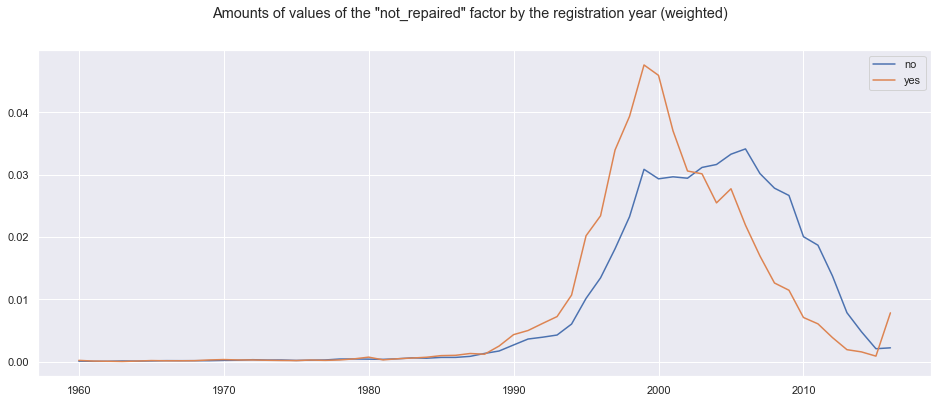

In [68]:
plt.figure(figsize=(16,6))
plt.suptitle('Amounts of values of the "not_repaired" factor by the registration year (weighted)')
plt.plot(not_repaired_pivot)
plt.legend(['no', 'yes'])
plt.show()

У старых машин *not_repaired* = yes встречается заметно чаще, чем у новых. С *not_repaired* = no - обратная ситуация.

Интерпретировать это достаточно сложно, начиная с названия столбца: "Не ремонтировалась ли Ваша машина?" - "Да, не ремонтировалась" или "Нет, не ремонтировалась". Второй момент - какой ремонт имеется в виду: текущий, капитальный, кузовной? О текущем вряд ли будут спрашивать в анкете. Если же речь идёт о капитальном или кузовном ремонте, то тогда это не очень стыкуется с диаграммой: чем больше срок эксплуатации, тем вероятнее, что за это время успеет произойти случай, при котором кузов получит повреждения; чем больше срок эксплуатации, тем при прочих равных вероятнее подойти к капремонту.

Ответов на эти вопросы у нас нет. Поэтому будем заполнять пропуски с помощью всё той же функции *knn_fillna*, опираясь на те признаки, которые могут иметь хотя бы какое-то отношение к факту ремонта.

Вот эти признаки: *reg_year*, *mileage*, *brand*. Кроме того, в этих признаках изначально не было пропусков (все значения - оригинальные), что поможет сделать предсказания точнее.

Заполним пропуски.

In [69]:
%%time
index_filled, condition, autos.not_repaired[condition] = knn_fillna(autos, 
                                                                   ['reg_year', 'mileage', 'brand'], 
                                                                   'not_repaired')

column "not_repaired"

NaN:
filled:   53622 (100.0%)
unfilled: 0 (0.0%)

F1-score:
valid sample: 0.865
constant:     0.878

Wall time: 9.84 s


Результат, на первый взгляд, - неудовлетворительный (модель не адекватна). Но всё относительно: ведь в итоге по факту более 86% пропусков заполнены верно.

Можно обучить модель ещё раз, добавив больше признаков, но мы этого делать не будем: фундаментально целевой признак *not_repaired* от других признаков не зависит (можно отловить лишь какие-то совпадения конкретно в этом датасете, т.е. прийти к переобучению). Также у нас в данном случае не стоит цель добиться лучшего результата, чем у константной модели. Результат получился вполне приемлемым, и этого достаточно. Заодно мы узнали, что с тем же успехом можно было бы обойтись заполнением пропусков модой, не применяя машинное обучение вообще.

In [70]:
autos.loc[index_filled].head()

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired,pics
0,480,small,1993,manual,75.0,golf,150000,3,petrol,volkswagen,no,0
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,no,0
7,14500,bus,2014,manual,125.0,c_max,30000,8,petrol,ford,no,0
8,999,small,1998,manual,101.0,golf,150000,12,petrol,volkswagen,no,0
11,999,wagon,1995,manual,115.0,passat,150000,11,petrol,volkswagen,no,0


##### pics

Посмотрим, какие есть значения в этом столбце.

In [71]:
autos.pics.value_counts(dropna=False)

0    308276
Name: pics, dtype: int64

Оказалось, что весь столбец заполнен нулями. Тогда он не нужен, и его необходимо удалить.

Удалим столбец *pics*.

In [72]:
autos.drop(columns='pics', inplace=True)
autos.head(1)

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired
0,480,small,1993,manual,75.0,golf,150000,3,petrol,volkswagen,no


#### Обработка незаполненных пропусков

In [73]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308276 entries, 0 to 308275
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         308276 non-null  int64  
 1   vehicle_type  306588 non-null  object 
 2   reg_year      308276 non-null  int64  
 3   gearbox       306982 non-null  object 
 4   power         305462 non-null  float64
 5   model         306588 non-null  object 
 6   mileage       308276 non-null  int64  
 7   reg_month     308276 non-null  object 
 8   fuel          306673 non-null  object 
 9   brand         308276 non-null  object 
 10  not_repaired  308276 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 25.9+ MB


Посмотрим, сколько осталось пропусков по столбцам, а также сколько всего осталось строк, содержащих хотя бы один пропуск.

In [74]:
pd.isna(autos).sum()

price              0
vehicle_type    1688
reg_year           0
gearbox         1294
power           2814
model           1688
mileage            0
reg_month          0
fuel            1603
brand              0
not_repaired       0
dtype: int64

In [75]:
autos_isna = pd.isna(autos)
autos_isna['summary'] = autos_isna.apply(lambda x: np.any(x), axis=1)

In [76]:
autos_isna[autos_isna.summary == True].count().max()

4241

Таких строк - не много. Удалим их.

In [77]:
autos.dropna(inplace=True)
autos.reset_index(drop=True, inplace=True)
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304035 entries, 0 to 304034
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         304035 non-null  int64  
 1   vehicle_type  304035 non-null  object 
 2   reg_year      304035 non-null  int64  
 3   gearbox       304035 non-null  object 
 4   power         304035 non-null  float64
 5   model         304035 non-null  object 
 6   mileage       304035 non-null  int64  
 7   reg_month     304035 non-null  object 
 8   fuel          304035 non-null  object 
 9   brand         304035 non-null  object 
 10  not_repaired  304035 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 25.5+ MB


#### Завершение предобработки

Приведём столбец *power* к типу данных int.

In [78]:
autos.power = autos.power.astype('int')
autos.head()

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired
0,480,small,1993,manual,75,golf,150000,3,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,a5,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Посмотрим, сколько всего удалено объектов относительно исходного размера датасета.

In [79]:
# The function displays the amount of the deleted and the remained objects and, also, their parts of the original amount

def deleted_total():
    print('total amount of the deleted objects:\ndeleted:   {} of {} ({:.1%})\nremained: {} of {} ({:.1%})'
          .format(autos_original_amount - autos.shape[0],
                  autos_original_amount,
                  (autos_original_amount - autos.shape[0]) / autos_original_amount,
                  autos.shape[0],
                  autos_original_amount,
                  autos.shape[0] / autos_original_amount
                 )
         )

In [80]:
deleted_total()

total amount of the deleted objects:
deleted:   50334 of 354369 (14.2%)
remained: 304035 of 354369 (85.8%)


Данные очищены от дубликатов, выбросов и аномалий. Пропуски заполнены.

Предобработка данных завершена.

## Подготовка данных к применению в моделях

### Применяемые алгоритмы и методы

В исследовании будем применять следующие алгоритмы машинного обучения:
* *Random Forest*;
* *Linear Regression*;
* *Light GBM* (разработка компании *Microsoft*).

В датасете имеются количественные и категориальные признаки.

Количественные признаки необходимо масштабировать. Различие между некоторыми из них достигает четырёх порядков, а это может негативно повлиять на обучение: признаки с наименьшими значениями будут очень слабо влиять на результат, и обучение будет зависеть в большей степени от самого "сильного" признака. Масштабирование выполним с помощью метода *StandardScaler* библиотеки *scikit-learn*.

Для алгоритмов *Random Forest* и *Linear Regression* категориальные признаки будем преобразовывать с помощью dummy-схемы, применяя метод *pandas.get_dummies()*. Для алгоритма *Light GBM* категориальные признаки преобразуем с применением метода *OrdinalEncoder*: каждое уникальное строковое значение заменяется уникальным номером (в пределах одного столбца).

### Преобразование признаков

#### Списки, массивы

In [81]:
feat_num = ['reg_year', 'power', 'mileage']
feat_cat = ['vehicle_type', 'gearbox', 'model', 'reg_month', 'fuel', 'brand', 'not_repaired']

features = autos.drop(columns=['price'], axis=1)
target = autos.price

#### Количественные признаки

In [82]:
scaler = StandardScaler()

features_scl = features.copy()
features_scl[feat_num] = scaler.fit_transform(features_scl[feat_num])
features_scl.head(3)

,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired
0,small,-1.486592,manual,-0.860402,golf,0.581799,3,petrol,volkswagen,no
1,coupe,1.340355,manual,1.359384,a5,-0.096647,5,gasoline,audi,yes
2,suv,0.240986,auto,0.838217,grand,-0.096647,8,gasoline,jeep,no


#### Категориальные признаки

##### OneHotEncoder

Для алгоритмов *Random Forest* и *Linear Regression*.

In [83]:
features_scl_ohe = pd.get_dummies(features_scl, drop_first=True)
features_scl_ohe.head(3)

,reg_year,power,mileage,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,...,reg_month_6,reg_month_7,reg_month_8,reg_month_9,fuel_electric,fuel_gasoline,fuel_hybrid,fuel_lpg,fuel_other,fuel_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes
0,-1.486592,-0.860402,0.581799,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1.340355,1.359384,-0.096647,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.240986,0.838217,-0.096647,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### OrdinalEncoder

Для алгоритма *Light GBM*.

In [84]:
enc = OrdinalEncoder()
features_scl_ord = features_scl.copy()

features_scl_ord[feat_cat]= enc.fit_transform(features_scl_ord[feat_cat])
features_scl_ord.head(3)

,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel,brand,not_repaired
0,5.0,-1.486592,1.0,-0.860402,116.0,0.581799,5.0,6.0,38.0,0.0
1,2.0,1.340355,1.0,1.359384,30.0,-0.096647,7.0,2.0,1.0,1.0
2,6.0,0.240986,0.0,0.838217,117.0,-0.096647,10.0,2.0,14.0,0.0


Также нам понадобятся числовые индексы (номера столбцов) категориальных признаков: они передаются в модель именно в таком виде.

In [85]:
feat_cat_idx = pd.Series(features.columns)
feat_cat_idx = feat_cat_idx[feat_cat_idx.isin(feat_cat) == True].index.tolist()
feat_cat_idx

[0, 2, 4, 6, 7, 8, 9]

## Вывод по подготовке данных

После ознакомления с данными и переименования столбцов были выявлены и удалены ненужные, не влияющие на цену столбцы: *crawled*, *created*, *postal_code*, *last_seen* (*created* был удалён позже, так как был ещё нужен для анализа одного из столбцов). Также были удалены неинформативные строки - те, которые почти целиком состояли из пропусков. Удалены дубликаты.

Индивидуально по каждому столбцу: заполнены пропуски, удалены выбросы, обработаны аномалии, выполнено приведение типа данных там, где было необходимо.

Заполнение пропусков выполнено при помощи **машинного обучения** (алгоритм Метод ближайших соседей - классификатор и регрессор). В результате повысилась точность и сократилось время на проведение исследовательского анализа (закономерности в данных, необходимые для заполнения, модель выявляет сама).

В результате предобработки было **удалено** 14.2% данных. Учитывая размер датасета (более 300k объектов осталось), такое удаление - приемлемо. Такое уменьшение размера выборки не должно отрицательно сказаться на обучении в данном случае.

Данные были подготовлены к применению в моделях. Выполнено **масштабирование** количественных и **преобразование** категориальных признаков. Для алгоритмов *Random Forest* и *Linear Regression* категориальные признаки преобразованы с помощью dummy-схемы, а для алгоритма *Light GBM* - с помощью метода *OrdinalEncoder* (такой способ, согласно документации *Light GBM*, - предпочтительнее).

В результате данные полностью готовы к применению в моделях машинного обучения. 

# 2. Обучение моделей

##  Функции

In [86]:
# The function splits a sample into the train, the valid and the test samples.

def splitting_func(features, target, cross_val=True):
    X, X_test, y, y_test = train_test_split(features,
                                            target,
                                            test_size=0.20,
                                            random_state=r_state)

    # Dividing between the train and the test samples with ratio 4:1 in case auto cross-validation used
    if cross_val:
        print('shapes of the samples:\nX_train: {}\nX_test:  {}\ny_train: {}\ny_test:  {}'
              .format(X.shape, X_test.shape, y.shape, y_test.shape))

        return X, X_test, y, y_test
    
    # Dividing between the train, the valid and the test samples with ratio 3:1:1 (full flexibility of handling the samples)
    else:
        X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                              y,
                                                              test_size=0.25,
                                                              random_state=r_state)

        print('shapes of the samples:\nX_train: {}\nX_valid: {}\nX_test:  {}\ny_train: {}\ny_valid: {}\ny_test:  {}'
              .format(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape))

        return X_train, X_valid, X_test, y_train, y_valid, y_test

In [87]:
# The function calculates the timedelta for two datetime values passed and then displays and returns it

def timedelta_func(datetime_1, datetime_2, on_the_display=False):
    delta = abs(datetime_2 - datetime_1)
    
    # deciseconds (1 ds = 0.1 s)
    ds = round((delta.microseconds * 1e-5), 0) + delta.seconds * 10 + delta.days * 8.64e5
    
    h = (ds - math.fmod(ds, 36000)) / 36000
    m = (math.fmod(ds, 36000) - math.fmod(ds, 600)) / 600
    s = (math.fmod(ds, 600) - math.fmod(ds, 10)) / 10
    ds = math.fmod(ds, 10)

    duration = '{:.1f}s'.format(s + ds * 0.1)
    if m > 0.0:
        duration = f'{int(m)}min ' + duration
    if h > 0.0:
        duration = f'{int(h)}h ' + duration

    if on_the_display == True:
        print(duration)
    
    # milliseconds (1 ms = 0.001 s):
    return int(round((delta.microseconds * 1e-3), 0) + delta.seconds * 1000 + delta.days * 8.64e7), duration

In [88]:
# The function fits the model using cross-validation, computes the results and, finally, tests it on the test sample

def model_computing(estimator, parameters, X_train, X_test, y_train, y_test,
                    scorer='neg_mean_squared_error', jobs=-1, cv=2, output=True):
    
    # Creating the GridSearchCV object
    time_0 = dt.datetime.now()
    params = parameters.copy()
    model = GridSearchCV(estimator=estimator,
                         param_grid=params, 
                         scoring=scorer,
                         n_jobs=jobs,
                         cv=cv
                        )
    
    # Searching the best params on the train sample using cross-validation
    time_1 = dt.datetime.now()
    model.fit(X_train, y_train)
    time_2 = dt.datetime.now()
    
    # The best validation results (or a single result)
    rmse = np.sqrt(np.abs(model.best_score_))
    best_params = model.best_params_
    
    # Applying the best results
    for key in best_params.keys():
        params[key] = best_params[key]
    
    # Testing the best model
    model = estimator
    model.set_params(**params)
    
    time_3 = dt.datetime.now()
    model.fit(X_train, y_train)
    time_4 = dt.datetime.now()
    
    y_pred = model.predict(X_test)
    time_5 = dt.datetime.now()

    y_const = np.full_like(y_test, np.median(y_test))
    rmse_test = np.sqrt(np.abs(mean_squared_error(y_test, y_pred)))
    rmse_const = np.sqrt(np.abs(mean_squared_error(y_test, y_const)))
    std_dev = np.std(y_test)
    time_6 = dt.datetime.now()

    # Calculating the durations
    searching, searching_str = timedelta_func(time_1, time_2)
    training, training_str = timedelta_func(time_3, time_4)
    predicting, predicting_str = timedelta_func(time_4, time_5)
    wall, wall_str = timedelta_func(time_0, time_6)
    
    # Displaying the results
    if len(best_params) > 0:
        print('RMSE of the best model:\non the validation sample: {:.0f}\non the test sample: {:.0f}\n'
              .format(rmse, rmse_test))
        print(f'hyperparameters of the best model:\n{best_params}\n')
    else:
        print('RMSE:\non the validation sample: {:.0f}\nRMSE on the test sample: {:.0f}\n'
              .format(rmse, rmse_test))
    
    print('RMSE of the constant model: {:.0f}\nstd. dev. of the test sample: {:.0f}\n'
          .format(rmse_const, std_dev))
    
    print('time spending:\nsearching (using cross-val.): {}\ntraining: {}\npredicting: {}\nentire wall time: {}'
          .format(searching_str, training_str, predicting_str, wall_str))
    
    # Output
    if output:
        return [rmse, rmse_test, rmse_const, std_dev], [searching, training, predicting, wall], best_params, model
    else:
        None

## Обучение, валидация, тестирование

Описание результатов расчёта и детальный сравнительный анализ моделей будут приведены в отдельном разделе ниже. Здесь же ограничимся лишь представлением самих результатов, чтобы просто ознакомиться с ними.

### Random Forest

Разделим данные на две выборки - тренировочную и тестовую - в пропорции 4:1. Будем для этого использовать функцию *splitting_func*, в основе которой лежит функция *train_test_split* библиотеки *scikit-learn*.

In [89]:
X_train, X_test, y_train, y_test = splitting_func(features_scl_ohe, target)

shapes of the samples:
X_train: (243228, 317)
X_test:  (60807, 317)
y_train: (243228,)
y_test:  (60807,)


Создадим сетку гиперпараметров.

In [90]:
params = {
    'max_depth': np.arange(8, 16+1, 4, dtype='int'),
    'min_samples_leaf': np.geomspace(1, 8, 4, dtype='int')
}

params

{'max_depth': array([ 8, 12, 16]), 'min_samples_leaf': array([1, 2, 4, 7])}

С помощью функции *model_computing* (в её основе - функция *GridSearchCV*) выполним обучение нескольких моделей с различными значениями гиперпараметров и их валидацию (с применением кросс-валидации). Выберем лучшую модель по метрике *RMSE* и проверим её на тестовом наборе данных. Результаты сравним с константной моделью - медианой целевого вектора (проверка на адекватность). При этом будем фиксировать время выполнения каждого этапа.

In [91]:
metrics_rf, \
durations_rf, \
best_params_rf, \
model_rf = model_computing(RandomForestRegressor(n_estimators=50,
                                                 n_jobs=-1, 
                                                 random_state=r_state
                                                ),
                           params, 
                           X_train, X_test, y_train, y_test
                          )

RMSE of the best model:
on the validation sample: 1698
on the test sample: 1656

hyperparameters of the best model:
{'max_depth': 16, 'min_samples_leaf': 2}

RMSE of the constant model: 4851
std. dev. of the test sample: 4547

time spending:
searching (using cross-val.): 15min 9.5s
training: 1min 39.1s
predicting: 0.4s
entire wall time: 16min 49.0s


### Linear Regression

Использовать будем те же выборки, что и в *Random Forest*. Они уже сформированы, заново создавать их не нужно.

Так как гиперпараметров у алгоритма нет, подбирать ничего тоже не нужно.

Расчёты выполним с помощью функции *model_computing*.

In [124]:
metrics_lr, \
durations_lr, \
best_params_lr, \
model_lr = model_computing(LinearRegression(),
                           {}, 
                           X_train, X_test, y_train, y_test
                          )

RMSE:
on the validation sample: 2931
RMSE on the test sample: 2940

RMSE of the constant model: 4851
std. dev. of the test sample: 4547

time spending:
searching (using cross-val.): 0.4s
training: 0.1s
predicting: 0.0s
entire wall time: 0.4s


*RMSE* значительно больше (хуже), чем у Случайного Леса. Линейная регрессия плохо работает с категориальными признаками, а количественных - всего три. Слишком малое количество реально влияющих признаков отрицательно сказывается на качестве обучения. Попробуем выполнить расчёт, подав в модель **только количественные** признаки.

In [125]:
model_computing(LinearRegression(),
                {}, 
                X_train[feat_num], X_test[feat_num], y_train, y_test,
                output=False
               )

RMSE:
on the validation sample: 3083
RMSE on the test sample: 3094

RMSE of the constant model: 4851
std. dev. of the test sample: 4547

time spending:
searching (using cross-val.): 0.2s
training: 0.0s
predicting: 0.0s
entire wall time: 0.3s


Результат **близок** к предыдущему. Подтверждается предположение о том, что реально влияют на обучение только три количественных признака, а семь категориальных - влияют незначительно.

В итоге модель **недообучена**, но мы видим, что это происходит на фоне весьма **большого** размера обучающей выборки (240k+). Имеет место одна из двух возможных причин:
* данных всё равно недостаточно;
* зависимости, существующие в данных, - нелинейные и плохо аппроксимируются прямыми.

Чтобы проверить это, обучим модель на выборке, меньшей в 240 раз.

In [129]:
lr_index = X_train.sample(n=1000).index

model_computing(LinearRegression(),
                {}, 
                X_train.loc[lr_index], X_test, y_train.loc[lr_index], y_test,
                output=False
               )

RMSE:
on the validation sample: 3107
RMSE on the test sample: 2951

RMSE of the constant model: 4851
std. dev. of the test sample: 4547

time spending:
searching (using cross-val.): 0.1s
training: 0.0s
predicting: 0.0s
entire wall time: 0.1s


Обучив модель на выборке размером 1000 объектов, мы получили примерно **такой же** результат, что и на полной выборке. Другими словами, модель уже на малом количестве данных показала свой максимум, и с дальнейшим увеличением размера выборки (даже в сотни раз) лучше уже не становится.

Однозначно приходим к выводу о том, что рассматриваемые данные **плохо** описываются линейной функцией.

### Light GBM

#### Расчёт моделей *Light GBM*

Разделим данные на две выборки - тренировочную и тестовую - в пропорции 4:1 с помощью функции *splitting_func*.

In [138]:
X_train, X_test, y_train, y_test = splitting_func(features_scl_ord, target)

shapes of the samples:
X_train: (243228, 10)
X_test:  (60807, 10)
y_train: (243228,)
y_test:  (60807,)


Создадим сетку гиперпараметров.

In [151]:
params = {
    'num_leaves': np.geomspace(1, 16, 5, dtype='int') * 100,
    'max_depth': np.arange(8, 16+1, 4, dtype='int'),
}

params

{'num_leaves': array([ 100,  200,  400,  700, 1600]),
 'max_depth': array([ 8, 12, 16])}

Расчёты выполним с помощью функции *model_computing* аналогично расчётам, выполненным ранее.

In [152]:
metrics_lgb, \
durations_lgb, \
best_params_lgb, \
model_lgb = model_computing(lgb.LGBMRegressor(learning_rate=0.05,
                                              boosting_type='gbdt',
                                              n_estimators=100,
                                              categorical_feature=feat_cat_idx,
                                              n_jobs=-1,
                                              random_state=r_state,
                                              ),
                            params, 
                            X_train, X_test, y_train, y_test
                           )

RMSE of the best model:
on the validation sample: 1575
on the test sample: 1537

hyperparameters of the best model:
{'max_depth': 16, 'num_leaves': 700}

RMSE of the constant model: 4851
std. dev. of the test sample: 4547

time spending:
searching (using cross-val.): 50.5s
training: 5.0s
predicting: 0.3s
entire wall time: 55.7s


#### Важность признаков в лучшей модели *Light GBM*

Рассмотрим уровни важности признаков.

In [153]:
feature_importances_lgb = model_lgb.feature_importances_
feature_importances_lgb = pd.DataFrame(data=[features_scl_ord.columns,
                                             feature_importances_lgb]
                                      ).T

feature_importances_lgb.columns = ['feature', 'importance']
feature_importances_lgb = feature_importances_lgb.sort_values(by='importance', ascending=False)
feature_importances_lgb.reset_index(drop=True, inplace=True)

feature_importances_lgb

,feature,importance
0,power,19537
1,reg_year,13767
2,mileage,10376
3,model,8183
4,reg_month,5143
5,brand,3502
6,vehicle_type,3237
7,not_repaired,2864
8,gearbox,2454
9,fuel,837


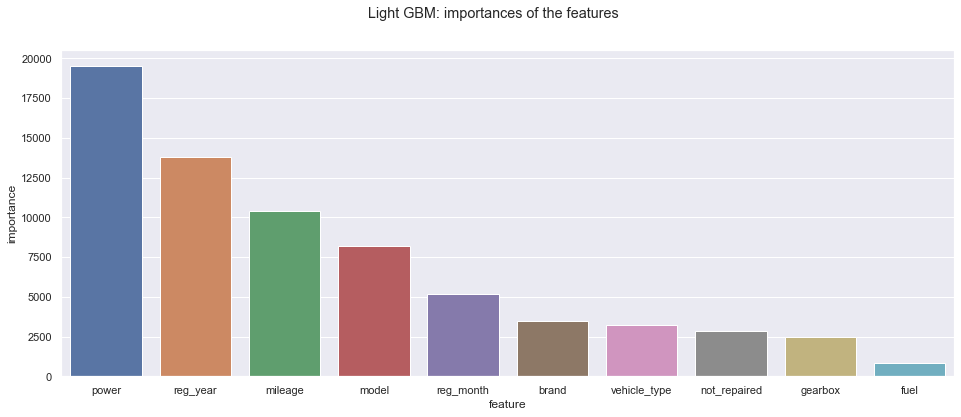

In [154]:
plt.figure(figsize=(16, 6))
plt.suptitle('Light GBM: importances of the features')

sns.barplot(x='feature',
            y='importance',
            data=feature_importances_lgb
           )

plt.show()

Признаки, сильнее всего влияющие на цену: **мощность**, **год выпуска**, **пробег**, **модель**. Вполне ожидаемо. Не последнюю роль играет **месяц**: подтверждается предложенное выше предположение, что иногда бывает важно, в начале или в конце года был выпущен автомобиль. Рейтинг замыкает с большим отрывом **тип топлива**: возможно, при выборе автомобиля он играет далеко не последнюю роль, но вот на цене он практически не сказывается.

## Вывод по обучению моделей

Рассматривались три алгоритма: *Random Forest* (Случайный лес), *Linear Regression* (Линейная регрессия), *Light GBM* (Градиентный бустинг).

По алгоритмам Случайный лес и Градиентный бустинг были разработаны **сетки гиперпараметров**, построены модели со всеми комбинациями этих гиперпараметров, и в результате для каждого алгоритма была определена **лучшая** модель - та, у которой значение метрики *RMSE* - минимальное. Гиперпараметры лучших моделей сохранены.

По алгоритму Линейной регрессии для определённого набора данных можно создать только **одну** модель (так как в её основе - решение матричного уравнения). Эта модель также была создана.

Наряду с качеством предсказания, критерием оценки модели в данной задаче является **затрачиваемое время**: время обучения модели и скорость предсказания. Эти данные были зафиксированы.

Для проверки моделей на **адекватность** были рассчитаны *RMSE* константной модели (константа - медиана вектора целевого признака) и стандартное отклонение вектора целевого признака. Эти данные также были зафиксированы.

Перебор гиперпараметров, обучение модели с применением кросс-валидации, выбор и тестирование лучшей модели, расчёт метрик (включая константную модель), фиксация затраченного времени, вывод результатов на экран и возврат их в переменные - всё это реализовано в **отдельной функции**.

Линейная регрессия показала результат по качеству предсказания заметно **ниже**, чем Случайный лес и Градиентный бустинг (их результаты, в свою очередь, между собой близки), и для установления причины было проведено **дополнительное** исследование. Построены ещё две модели Линейной регрессии:
* на входе - только количественные признаки (3 признака из 10);
* размер выборки уменьшен в 240 раз (n=1000).

Результат практически не изменился, а это означает, что причина кроется в самих данных: имеющиеся в них зависимости - **нелинейные**, и поэтому плохо аппроксимируются прямыми.

Один из атрибутов класса алгоритма Градиентного бустинга - **важность признаков**. Это позволило рассмотреть уровни важности признаков в полученной модели. Наибольшее влияние на цену оказывают мощность, год выпуска, пробег, модель. Наименьшее - тип топлива.

Модели готовы к анализу.

# 3. Анализ моделей

## Функции

In [155]:
# The function plots the barplot for the values to compare them

def comparison_func(x_list, y_list, suptitle):
    plt.figure(figsize=(16, len(x_list)*0.8 ))
    plt.suptitle(suptitle)
    sns.barplot(x=x_list, y=y_list, data=comparison.T, orient='h')
    plt.show()

## Вводная часть

Согласно техническому заданию, заказчику важны:
* качество предсказания;
* время обучения;
* скорость предсказания.

Выполним сравнительный анализ алгоритмов, сравнивая между собой по этим пунктам лучшие из рассчитанных моделей.

Сначала сведём необходимые данные в таблицу.

In [156]:
algorithms = ['Random Forest', 'Linear Regression', 'Light GBM']
compare_items = ['RMSE, \u20AC', 'training time, ms', 'predicting time, ms']

comparison = pd.DataFrame(data=[[metrics_rf[1], metrics_lr[1], metrics_lgb[1]],
                                [durations_rf[1], durations_lr[1], durations_lgb[1]],
                                [durations_rf[2], durations_lr[2], durations_lgb[2]]
                               ],
                          index=compare_items,
                          columns=algorithms
                         )

comparison = comparison.astype('int')
comparison

,Random Forest,Linear Regression,Light GBM
"RMSE, €",1655,2940,1537
"training time, ms",99090,78,4968
"predicting time, ms",374,2,296


Также зафиксируем *RMSE* константной модели и стандартное отклонение вектора целевого признака тестовой выборки.

Функция *model_computing* возвращает эти данные тоже. Поскольку они являются характеристиками самого датасета, а не модели, мы можем взять их из возвращённых данных любой модели. Например, линейной регрессии.

In [157]:
rmse_const = int(metrics_lr[2])
std_dev = int(metrics_lr[3])

print('RMSE of the constant model: {}\nstandard deviation of the target: {}'.format(rmse_const, std_dev))

RMSE of the constant model: 4850
standard deviation of the target: 4546


## Сравнительный анализ качества предсказания

Визуализируем метрики качества моделей. Помимо *RMSE* моделей, покажем на этой же диаграмме *RMSE* константной модели и стандартное отклонение вектора целевого признака.

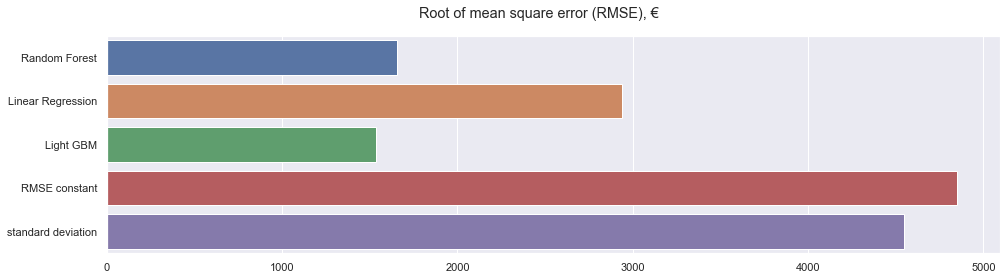

In [158]:
comparison_func([*comparison.T.iloc[:, 0].values, rmse_const, std_dev],
                [*comparison.T.index, 'RMSE constant', 'standard deviation'],
                'Root of mean square error (RMSE), \u20AC')

Прежде всего необходимо отметить, что все модели - **адекватные**. Каждая из них делает предсказания значительно точнее, чем та, что предсказывает во всех случаях медиану целевого признака. RMSE значительно меньше стандартного отклонения целевого признака, что также является хорошим знаком: предсказания всё-таки лежат **в окрестностях** своих истинных значений, а не разбросаны случайным образом по всей выборке.

Сравнивая модели, начнём с Линейной регрессии. Как было показано выше, этот алгоритм не очень подходит для рассматриваемых данных, так как в них имеются **нелинейные** зависимости. Поэтому стандартное отклонение ошибки по сравнению с другими моделями отличается в большую сторону почти вдвое.

Качество предсказаний Случайного леса и Градиентного бустинга почти не различается. Близкие результаты, возможно, получились из-за **похожести** этих двух алгоритмов: и у того, и у другого в основе лежит принцип Решающего дерева. Качество предсказаний - достаточно **высокое**: данные хорошо ветвятся (поддаются эффективному разделению в узлах).

## Сравнительный анализ времени обучения

Визуализируем время обучения моделей.

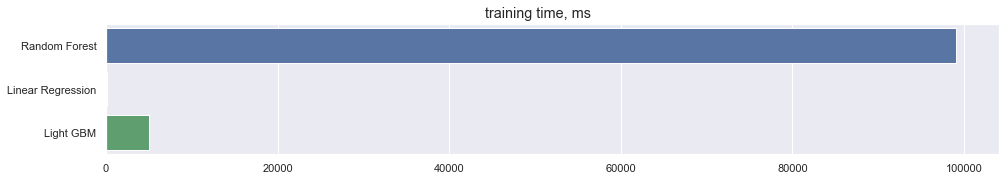

In [159]:
comparison_func(comparison.T.iloc[:, 1].values,
                comparison.T.index,
                'training time, ms')

Время различается на порядки. Построим то же самое на логарифмической шкале (точнее, логарифмируем сами значения). Так мы увидим, на сколько порядков они различаются.

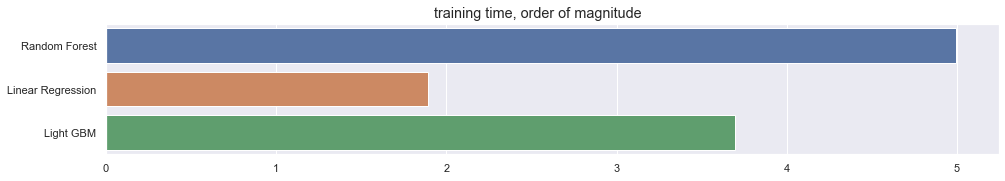

In [160]:
comparison_func(np.log10(comparison.T.iloc[:, 1].values),
                comparison.T.index,
                'training time, order of magnitude')

Быстрее всех обучается модель линейной регрессии (на машине автора - менее 100 мс). Второе место - у градиентного бустинга (примерно 10 с). Дольше всех обучается случайный лес (почти полторы минуты).

Линейная регрессия справилась с задачей **быстрее всех**. Возможные причины: линейная регрессия не работает с категориальными признаками, а количественных - всего 3 (из 10), и обсчитать их можно быстрее; решение матричного уравнения (один раз) заняло меньшее время по сравнению с *Light GBM*: градиентный спуск имеет меньшую вычислительную сложность, но, так как это ансамбль (число потоков в нашем случае равно 100), вычисление выполняется 100 раз. Отсюда и получилась разница во времени в два порядка.

Алгоритм *Light GBM* отработал на порядок **быстрее**, чем *Random Forest*, из-за меньшего числа операций: количество итераций ограничено по условию, а ветвление продолжается не по всем веткам, как в случайном лесе (каждая ветка должна дойти до листа с минимальным отклонением или упереться в то или иное ограничение, установленное гиперпараметром), а только по той ветке, в которой ошибка оказалась максимальной. В результате сокращается количество ненужных вычислений, и модель за отведённое ей число итераций (вкупе с правильно подобранным шагом спуска) успевает дойти до приемлемого результата (дальнейшие шаги уже практически не улучшают результат).

## Сравнительный анализ скорости предсказания 

Визуализируем скорость предсказания моделей.

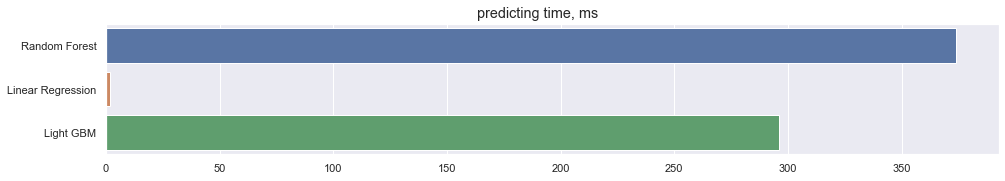

In [161]:
comparison_func(comparison.T.iloc[:, 2].values,
                comparison.T.index,
                'predicting time, ms')

Время различается на порядки, как и в предыдущем случае. Построим диаграмму по логарифмированным значениям.

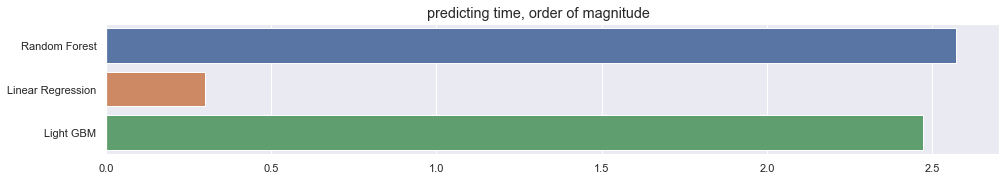

In [162]:
comparison_func(np.log10(comparison.T.iloc[:, 2].values),
                comparison.T.index,
                'predicting time, order of magnitude')

Скорости предсказания различаются по алгоритмам примерно так же, как и время обучения: Линейная регрессия - на два порядка **быстрее**, чем Случайный лес и Градиентный бустинг.

Так происходит, вероятно, из-за разницы вычислительных сложностей полученных моделей: перемножать матрицу с вектором оказалось в данном случае намного быстрее, чем прогонять каждый объект через определённый набор условий (параметров), подобранных во время обучения.

Именно с этой скоростью каждый пользователь будет сталкиваться **непосредственно**: это и есть длительность ожидания расчёта цены его автомобиля. И здесь необходимо отметить, что во всех трёх случаях речь идёт о **доле секунды**, т.е с позиции пользователя затраченное на расчёт время пренебрежимо **мало**. Если сервер будет успевать обрабатывать поступающие запросы, то приемлем любой вариант. С точки зрения запаса по **масштабируемости** сервиса Линейная регрессия обеспечивает запас примерно в 100 раз больше, чем остальные модели.

## Вывод по анализу моделей

Сравнительный анализ моделей выполнялся по следующим характеристикам:
* качество предсказания;
* время обучения;
* скорость предсказания.

Все три рассматриваемые модели прошли проверку на **адекватность**: значения метрики *RMSE* у них ниже, чем у константной модели (в 1.6 - 3.2 раза). Такое же различие - между *RMSE* моделей и стандартным отклонением целевого признака (что говорит об относительно небольшом разбросе предсказаний вокруг истинных значений).

Наиболее **высокое** качество предсказаний - у Градиентного бустинга. Немного ниже - у Случайного леса. Линейная регрессия показывает качество **вдвое** ниже, чем у остальных.

С временными затратами - обратная ситуация. Линейная регрессия - **быстрее** на два порядка, чем две другие модели. И по времени обучения, и по скорости предсказания.

По скорости предсказания Случайный лес и Градиентный бустинг показали практически **равные** результаты. Вероятно, это связано с тем, что в обоих случаях в основе - Решающее дерево. Поэтому и там, и там предсказание определяется как результат прохода каждого объекта через множество условий (в этом и состоит суть модели). Вероятно, параметры этих двух моделей в результате обучения получаются **схожими**, что приводит к схожим результатам и схожим временным затратам на предсказание.

По времени обучения Градиентный бустинг на порядок **быстрее**, чем Случайный лес. Столь значительная разница объясняется различием в самом **процессе** обучения: Случайный лес прогнозирует значение самого целевого признака (формирует к нему путь, создавая узлы с условиями), а Градиентный бустинг - значение ошибки (чтобы затем её вычесть и таким образом приблизиться на шаг). Кроме того, Градиентный бустинг строит ветви не из всех узлов, а только из тех, где ошибка - максимальна. Сокращается количество вычислений, а вместе с ним - затраченное время.

# Общий вывод

##### Подготовка данных

Выполнена предобработка данных: удалены дубликаты, выбросы, обработаны аномалии, заполнены пропуски, выполнено приведение типов. Удалены ненужные столбцы. Заполнение пропусков выполнялось с применением машинного обучения. В результате пропуски были заполнены максимально близко к реальности, а потеря данных составила всего 14,2%. Снижение потерь привело бы к большему искажению данных, что нецелесообразно в связи с большим размером датасета.

Выполнена подготовка данных к применению в моделях: выполнено масштабирование количественных признаков, выполнено преобразование категориальных признаков:
* по dummy-схеме для алгоритмов *Random Forest* и *Linear Regression*;
* методом *OrdinalEncoder* для алгоритма *Light GBM*.

##### Обучение моделей

По каждому из трёх рассматриваемых алгоритмов построены модели. По алгоритмам *Random Forest* и *Light GBM*, кроме того, был выполнен подбор гиперпараметров для отыскания наиболее качественных моделей.

Качество модели *Linear Regression* получилось почти вдвое ниже, чем качество двух других. Построение двух дополнительных моделей (их обучение выполнялось на усечённых по столбцам и строкам выборках) показало, что причина - в данных. Имеющиеся данные плохо аппроксимируются прямыми.

Все три модели - адекватные: *RMSE* по сравнению с константной моделью ниже в 1.6 - 3.2 раза.

##### Анализ моделей

По качеству предсказаний лидирует модель *Light GBM*. *Random Forest* - немного уступает *Light GBM* в качестве. *Linear Regression* - качество почти вдвое ниже, чем у первых двух.

Как уже было показано выше, с Линейной регрессией ничего нельзя сделать: всё дело - в данных. Вместе с тем, необходимо отметить, что качество предсказаний модели *Linear Regression* всё-таки является удовлетворительным, а сама модель имеет и некоторые преимущества. А именно - скорость.

Модель *Linear Regression* обучается примерно в 100 раз быстрее, чем модель *Light GBM*, и примерно в 1000 раз быстрее, чем модель *Random Forest*. Таким образом, в этой дисциплине проигрывает *Random Forest*: он - самый медленный. При качестве предсказаний почти как у *Light GBM* он обучается в 10 раз дольше.

Скорость предсказания у модели *Linear Regression* примерно в 100 раз выше, чем у двух других моделей. *Light GBM* и *Random Forest* по скорости предсказания примерно одинаковы. Скорость предсказания непосредственно видит и оценивает пользователь. Поскольку речь идёт о долях секунды, для пользователя разница, скорее всего, будет не критична. А вот со стороны сервера при большом числе запросов эта разница может дать о себе знать во весь рост: чтобы успевать их обрабатывать, для выполнения расчётов потребуются более мощные ресурсы. Используя модель *Linear Regression*, сервер сможет обработать в 100 раз больше запросов в единицу времени.

##### Заключение

Каждая из рассмотренных моделей имеет как достоинства, так и недостатки. В контексте критериев, указанных в ТЗ, каждая модель представляет собой компромисс. Поэтому рекомендаций будет несколько:
* если требуется самая высокая точность предсказаний, то рекомендуется применять модель *Light GBM*;
* если имеются ограничения по доступной вычислительной мощности как для расчёта предсказаний, так и для обучения модели, то рекомендуется применять модель *Linear Regression*;
* *Random Forest* работает с тем же качеством и с той же скоростью, что и *Light GBM*, но обучается значительно медленнее, поэтому применять его вряд ли имеет смысл.